In [39]:
# Import Libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy


In [40]:
# Read the image

testImage = cv2.imread('./Data/Logs-860x360.jpg')

In [34]:
# Apply Canny after smoothing the image
minVal= 100
maxVal= 200
blur = cv2.blur(testImage,(5,5))
edges = cv2.Canny(blur, minVal, maxVal, 3, L2gradient=True)

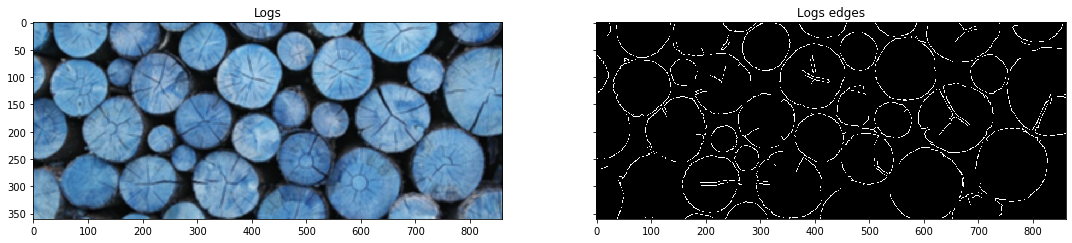

In [24]:
#Plot the blurred image alongside the edge image
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs')
ax1.imshow(blur, cmap='gray')


ax2.set_title('Logs edges')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(edges, cmap='gray')


In [31]:
# Count the number of contours and overlay the contours on the image
contours, hierarchy = cv2.findContours(edges,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#cv2.imshow('Canny Edges After Contouring', edged)
#cv2.waitKey(0)

print("Number of Contours found = " + str(len(contours)))
testImageDeepCopy = copy.deepcopy(testImage)
testImageContoured = cv2.drawContours(testImageDeepCopy, contours, -1, (0, 255, 0), 3)

Number of Contours found = 119


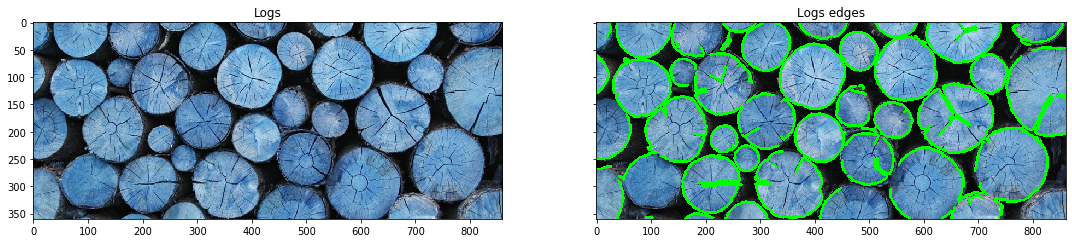

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs')
ax1.imshow(testImage, cmap='gray')


ax2.set_title('Logs edges')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageContoured)

As we can see from above, even with blurring the image, we still end up with a wrong estimate for the number of logs as it fails to eliminate strong crevices in the wood, the log surface is uneven which causes multiple breaks in the contour, some true log edges are now missing on the darker regions.

In [121]:
# Apply Hough transform on the blurred image.

# Convert to grayscale.
gray = cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
  
# Blur using 9 * 9 kernel.
grayBlurred = cv2.blur(gray, (9, 9))
detected_circles = cv2.HoughCircles(grayBlurred, cv2.HOUGH_GRADIENT, 1, 30, param1 = 100, param2 = 30, \
                                    minRadius = 10, maxRadius = 120)

#print(detected_circles)

In [119]:
# Draw circles that are detected.

testImageCircle= copy.deepcopy(testImage)
if detected_circles is not None:
  
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(testImageCircle, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(testImageCircle, (a, b), 1, (0, 0, 255), 3)
    #cv2.imshow("Detected Circle", testImageCircle)
    #cv2.waitKey(0)

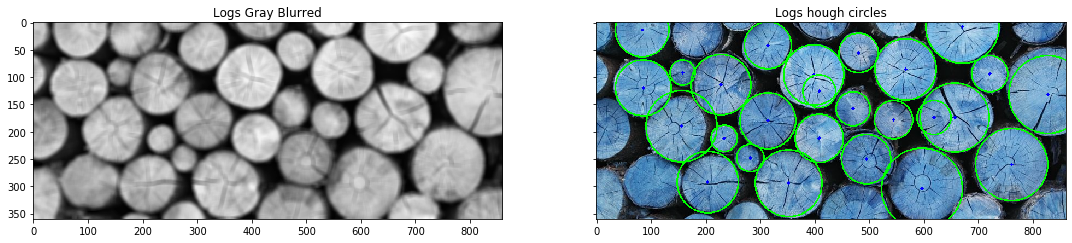

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs Gray Blurred')
ax1.imshow(grayBlurred, cmap='gray')


ax2.set_title('Logs hough circles')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageCircle)

As you can see, its really hard to tune these parameters to get the right amount of log contours detected. Some preprocessing operations may help

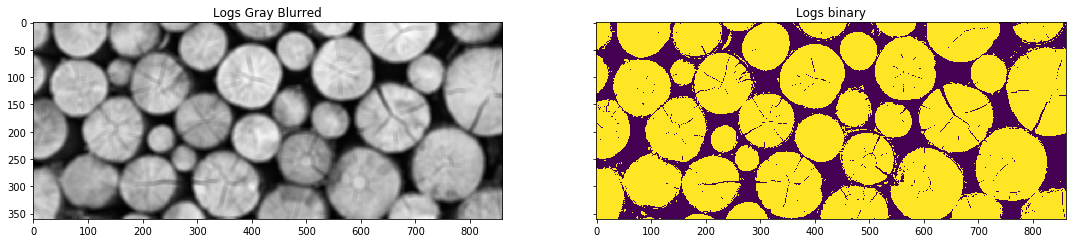

In [279]:
# Preprocess into a binary image 

th, binaryImage = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs Gray Blurred')
ax1.imshow(grayBlurred, cmap='gray')


ax2.set_title('Logs binary')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(binaryImage)

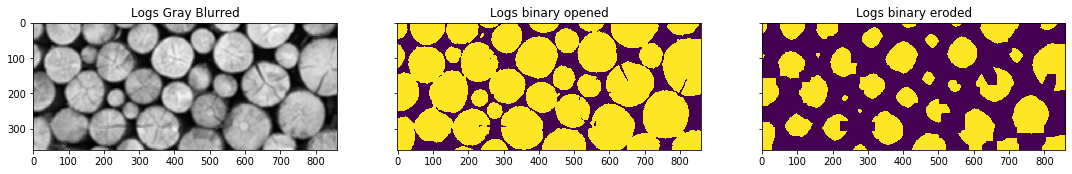

In [306]:
# Apply morphological opening and closing

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Remove noise by median filtering?

median = cv2.medianBlur(binaryImage, 5)
closedBinaryImage = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel2,iterations = 1)
openedBinaryImage = cv2.morphologyEx(closedBinaryImage, cv2.MORPH_OPEN, kernel1,iterations =3)
#closedBinaryImage = cv2.morphologyEx(openedBinaryImage, cv2.MORPH_CLOSE, kernel2,iterations = 3)

eroded2 = cv2.erode(openedBinaryImage, kernel3, iterations = 12)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs Gray Blurred')
ax1.imshow(grayBlurred, cmap='gray')


ax2.set_title('Logs binary opened')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(openedBinaryImage)

ax3.set_title('Logs binary eroded')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax3.imshow(eroded2)


In [290]:
detected_circles = cv2.HoughCircles(openedBinaryImage, cv2.HOUGH_GRADIENT, 1.1, 30, param1 = 200, param2 = 25, \
                                    minRadius = 10, maxRadius = 120)
#print(detected_circles)

In [291]:
# Draw circles that are detected.

testImageCircle= copy.deepcopy(testImage)
if detected_circles is not None:
  
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(testImageCircle, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(testImageCircle, (a, b), 1, (0, 0, 255), 3)
    #cv2.imshow("Detected Circle", testImageCircle)
    #cv2.waitKey(0)

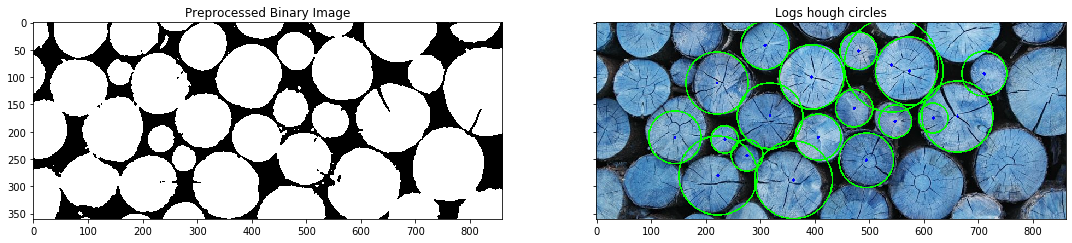

In [292]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Preprocessed Binary Image')
ax1.imshow(closedBinaryImage, cmap='gray')


ax2.set_title('Logs hough circles')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageCircle)

In [307]:
# Use contours followed by min enclosing circle detection
contours,hierarchy = cv2.findContours(eroded2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print('Total no. of contours:', len(contours))
testImageContours= copy.deepcopy(testImage)
for cnt in contours:
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(testImageContours,center,radius,(0,255,0),2)
    
testImageContours = cv2.drawContours(testImageContours, contours, -1, (255, 0,  0), 3)    

Total no. of contours: 38


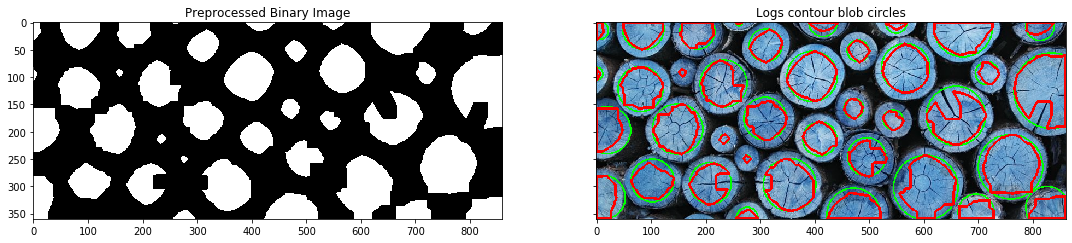

In [308]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Preprocessed Binary Image')
ax1.imshow(eroded2, cmap='gray')


ax2.set_title('Logs contour blob circles')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageContours)

As can be seen above, a relatively simple looking problem is actually very hard to implement and tune in a way that it would work out of the box for various cases. I have now spend some time to tune above parameters, and as you can see it can be done and i returns the correct count : 38 for the above case. But the goal of this notebook is to find a way to count objects with minimal tuning. We will try a simple blob detector next.

In [205]:
# Create a SimpleBlobDetector object
detector = cv2.SimpleBlobDetector_create()

# Detect blobs in the image
keypoints = detector.detect(closedBinaryImage)

print(keypoints)
# Draw circles on the original image
testImageBlob= copy.deepcopy(testImage)
for keypoint in keypoints:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
    r = int(keypoint.size / 2)
    cv2.circle(testImageBlob, (x, y), r, (0, 255, 0), 2)

[<KeyPoint 0x7f1f07eb1ea0>, <KeyPoint 0x7f1f07982870>, <KeyPoint 0x7f1f07982fc0>, <KeyPoint 0x7f1f07982f30>, <KeyPoint 0x7f1f07982a80>, <KeyPoint 0x7f1f07982c00>, <KeyPoint 0x7f1f073c65d0>]


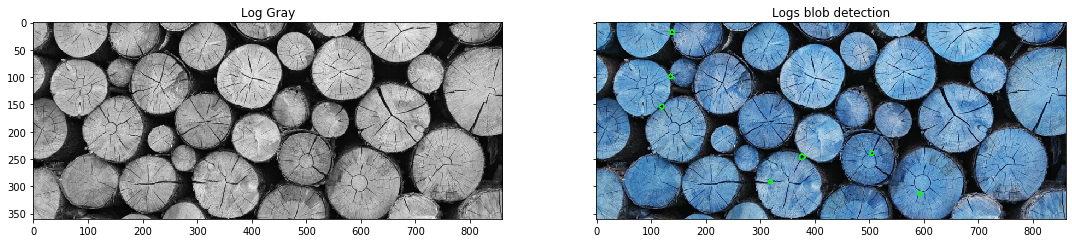

In [206]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Log Gray')
ax1.imshow(gray, cmap='gray')


ax2.set_title('Logs blob detection')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageBlob)